In [1]:
#### Normalisation ####

# Library size alludes to the types of cells(?) accomodated/selected for by the sequencing protocol. The size
# of the library must be taken into account when determining gene expression
# - but some quantification tools do this already and so don't need this type of normalisation (Cufflinks, RSEM)

# Most normalisation methods can be taken from bulk RNA-seq such as (UQ,SF,CPM,RPKM,FPKM,TPM)
# - CPM is the easiest way - You take each column (sample) and divide each element in that column by the column total * 1M.
#   But you must exclude spike ins from this calculation so that we can still correct for total RNA content. So we will
#   only use the endogenous genes.

calc_cpm <- function(expr_mat, spikes=NULL){
    norm_factor <- colSums(expr_mat[-spikes, ])
    return(t(t(expr_mat)/norm_factor)) * 10^6
}

# Problem of this approach is that if your sample contains genes that both very highly expressed and also differentially
# expressed across the cekks, then the total molecules in a cell may depend on whether that genes is on/off in the cell
# and so normalising by total molecules could hide this differential expression of those genes, or falsely create
# differential expression in the remaining genes

# - Other methods such RPKM, FPKM, and TPM are just variants on CPM which further adjust the counts by the length of the
#   respective gene/transcript.
# 
# One package that is optimises CPM for single-cell is the `scran` package which is good for large numbers of zero values
# per cell by pooling cells together and alculating a normalisation factor (similar to CPM) for the sum of each pool.
# Since each cell is found in many different pools, cell-specific factors have to be deconvoluted from the collection of
# pool specific factors using linear algebra.

# Three better methods we can use instead is:
#  SF "size factor" which is used by DESeq, a.k.a RLE "relative log expression" in edgeR
#  - You take the geometric mean of each gene across all cells. The SF for each cell is the median across genes to the
#    ratio of the expression to the gene's geometric mean.
#  - One drawback to this method is that since it uses the geometric mean, only genes with non-zero expression across all
#    cells can be used in the calculation, making NOT ideal for low-depth scRNASeq expreiments.
# 
calc_sf <- function(expr_mat, spikes=NULL){
    geomeans <- exp(rowMeans(log(expr_mat[-spikes, ])))
    # exponential of the mean log value of all cells for a given gene
    SF <- function(cnts){
        median((cnts/geomeans)[(is.finite(geomeans) & geomeans > 0)])
        # the median of a row of counts divided by the geometric mean on the condition that the geomeans is non-zero
        # for a particular gene
    }
    norm_factor <- apply(expre_mat[-spikes, ], 2, SF)
    return(t(t(expr_mat)/norm_factor))
}

# UQ "upper quartile" where you divide each column (sample) by the 75% quantile of counts for each library. This quantile
# is scaled by the median across cells to keep the absolute  level of expression reasonable consistent.
# - Again, for low-depth scRNA experiments the large number of undetected genes could results in the 75% quantile being 0
#   But we can overcome this by using a higher quantile or excluding zeros before the 75% quantile calc.

calc_uq <- function(expr_mat, spikes=NULL){
    UQ <- function(x){
        quantile(x[x > 0], 0.75)
    }
    uq <- unlist(apply(expr_mat[-spikes, ], 2, UQ))
    norm_factor <- uq /median(uq)
    return(t(t(expr_mat)/norm_factor))
}

# TMM "weighted trimmed mean of M-values" - where M-values are log2 fold changes between individual cells for a given gene.
# - You use one cell as a reference, and you calculate M-values for all other cells to this reference, removing the
#   top and bottom ~30% and then averaging the remaining values.
# - All non-reference cells are multiplied by the this factor, but this might not be good if you have not enough
#   non-zero genes left behind after trimming.

# The last way to normalise library site is to downsample the matrix so that each cell has roughly the same total number
# of molecules. 
# - The benefit of this method is that zero values will be introduced by downsampling, thus eliminating any biases
#   due to the differing numbers of detected genes.
# - But it is not deterministic, so you have to downsample many times to get robust results.

Down_Sample_Matrix <- function(expr_mat){
    min_lib_size <- min(colSums(expr_mat))   # take the lowest total read count across all samples
    down_sample <- function(x){
        prob <- min_lib_size / sum(x)
        return(unlist(lapply(x, function(y){
            rbinom(1, y, prob)
        })))
    }
    down_sampled_mat <- apply(expr_mat, 2, down_sample)
    return(down_sampled_mat)
}

# This is all very well and good, but how do we know which normalisation method is the best?
# - we can compare using PCA and via calculation of cell-wise relative log expression using scater's plotRLE()

calc_cell_RLE <- function(expr_mat, spikes = NULL){
    RLE_gene <- function(x){
        if (median(unlist(x)) > 0){
            log((x+1)/(median(unlist(x)) + 1))/log(2)
        }
        else {
            rep(NA, times = length(x))
        }
    }
    
    if (!is.null(spikes)){
        RLE_matrix <- t(apply(expr_mat[-spikes, ], 1, RLE_gene))
    }
    else {
        RLE_matrix <- t(apply(expr_mat, 1, RLE_gene))
    }
    cell_RLE <- apply(RLE_matrix, 2, median, na.rm = T)
    return(cell_RLE)
}

In [3]:
# Okay let's actually apply this to our UMI data

# load everything
library(scRNA.seq.funcs, quietly=TRUE)   # devtools::install_github("hemberg-lab/scRNA.seq.funcs")
library(scater, quietly=TRUE)
library(scran, quietly=TRUE)
options(stringsAsFactors = FALSE)
set.seed(1234567)
umi <- readRDS("tung/umi.rds")
umi.qc <- umi[rowData(umi)$use, colData(umi)$use]
endog_genes <- !rowData(umi.qc)$is_feature_control # non-ERCC

In [4]:
head(counts(umi))

,NA19098.r1.A01,NA19098.r1.A02,NA19098.r1.A03,NA19098.r1.A04,NA19098.r1.A05,NA19098.r1.A06,NA19098.r1.A07,NA19098.r1.A08,NA19098.r1.A09,NA19098.r1.A10,⋯,NA19239.r3.H03,NA19239.r3.H04,NA19239.r3.H05,NA19239.r3.H06,NA19239.r3.H07,NA19239.r3.H08,NA19239.r3.H09,NA19239.r3.H10,NA19239.r3.H11,NA19239.r3.H12
ENSG00000237683,0,0,0,1,0,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
ENSG00000187634,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
ENSG00000188976,3,6,1,3,4,2,3,6,2,4,⋯,2,2,5,2,3,3,1,0,2,2
ENSG00000187961,0,0,0,0,0,0,0,0,0,0,⋯,0,1,0,0,0,0,1,0,0,1
ENSG00000187583,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000187642,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


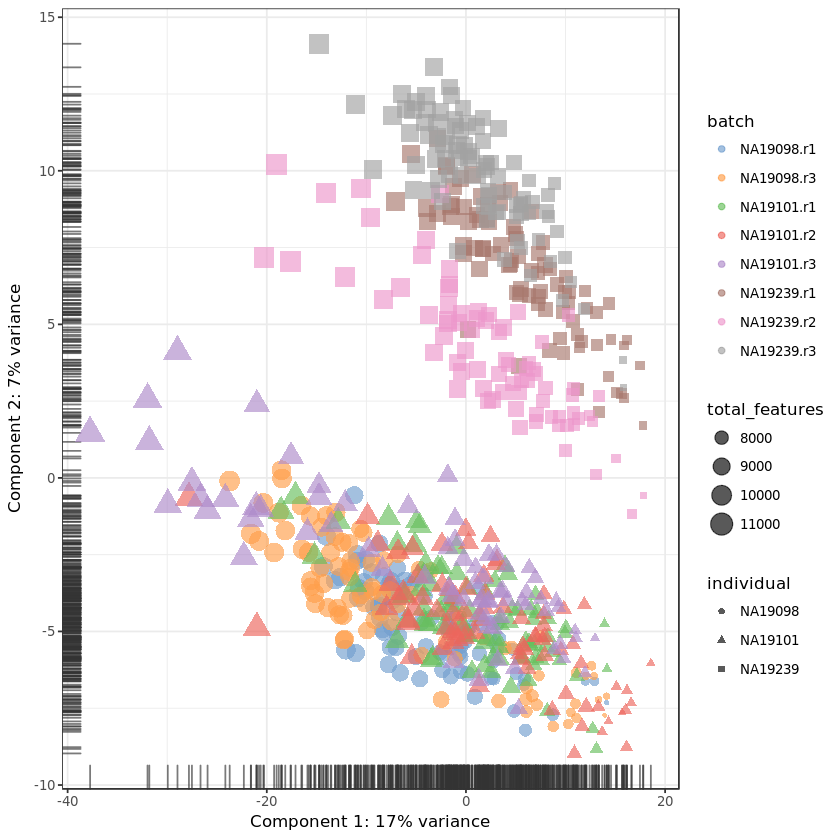

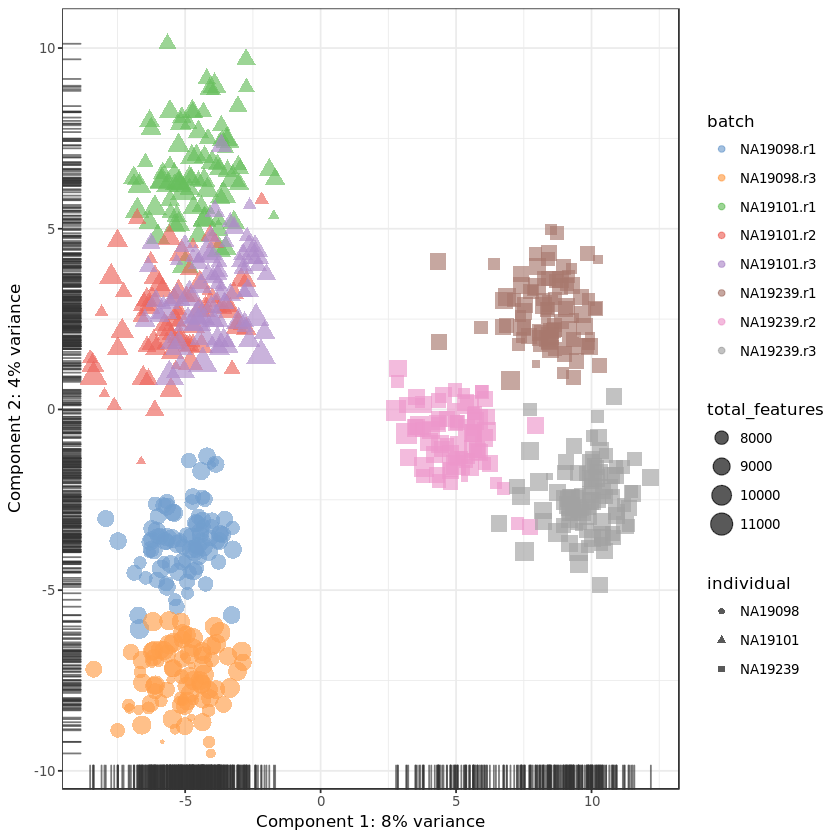

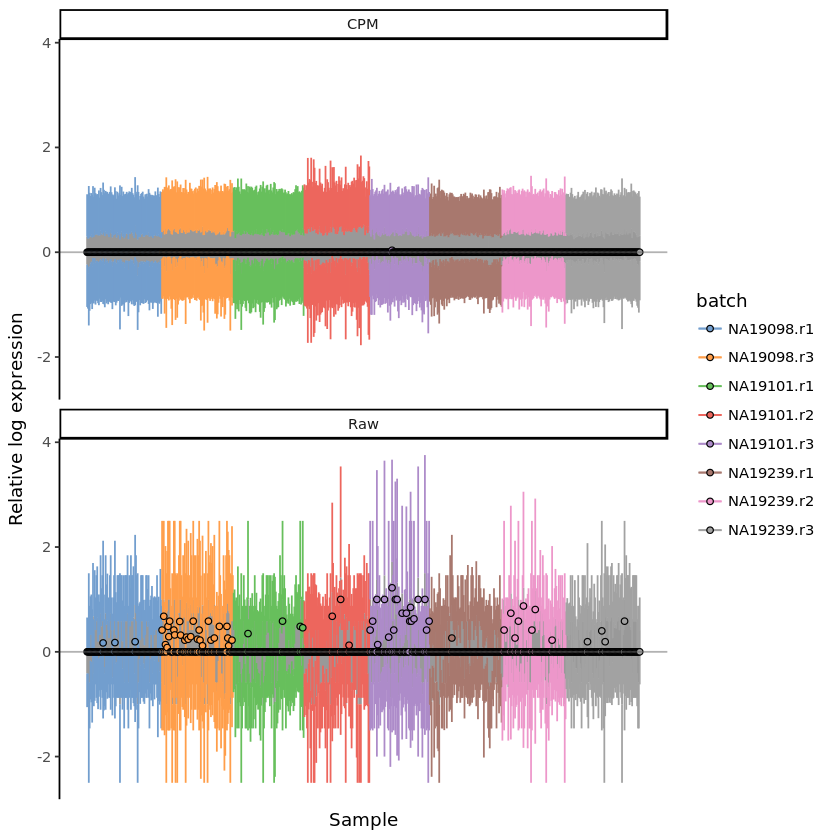

In [3]:
# Raw plot
plotPCA(
    umi.qc[endog_genes, ],
    exprs_values = "logcounts_raw",
    colour_by = "batch",
    size_by = "total_features",
    shape_by = "individual"
)

#CPM plot
logcounts(umi.qc) <- log2(calculateCPM(umi.qc, use.size.factors = FALSE) + 1)
plotPCA(
    umi.qc[endog_genes, ],
    colour_by = "batch",
    size_by = "total_features",
    shape_by = "individual"
)

# And a comparison of the two:
plotRLE(
    umi.qc[endog_genes, ], 
    exprs_mats = list(Raw = "logcounts_raw", CPM = "logcounts"),
    exprs_logged = c(TRUE, TRUE),
    colour_by = "batch"
)

Warning message in normalizeSCE(object, exprs_values = exprs_values, return_log = return_log, :
“spike-in transcripts in 'ERCC' should have their own size factors”

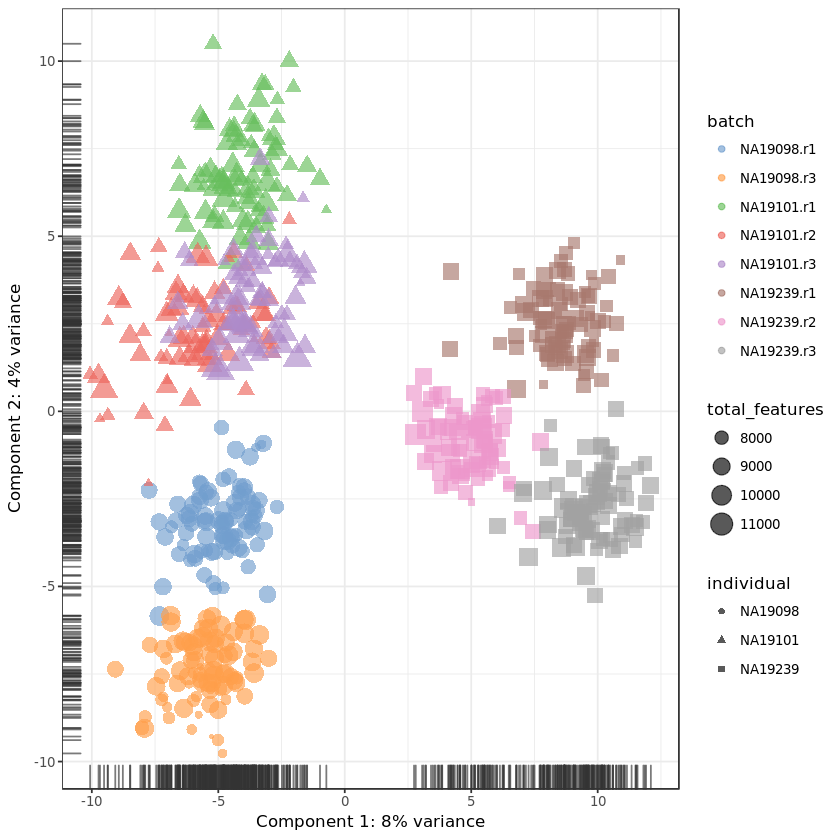

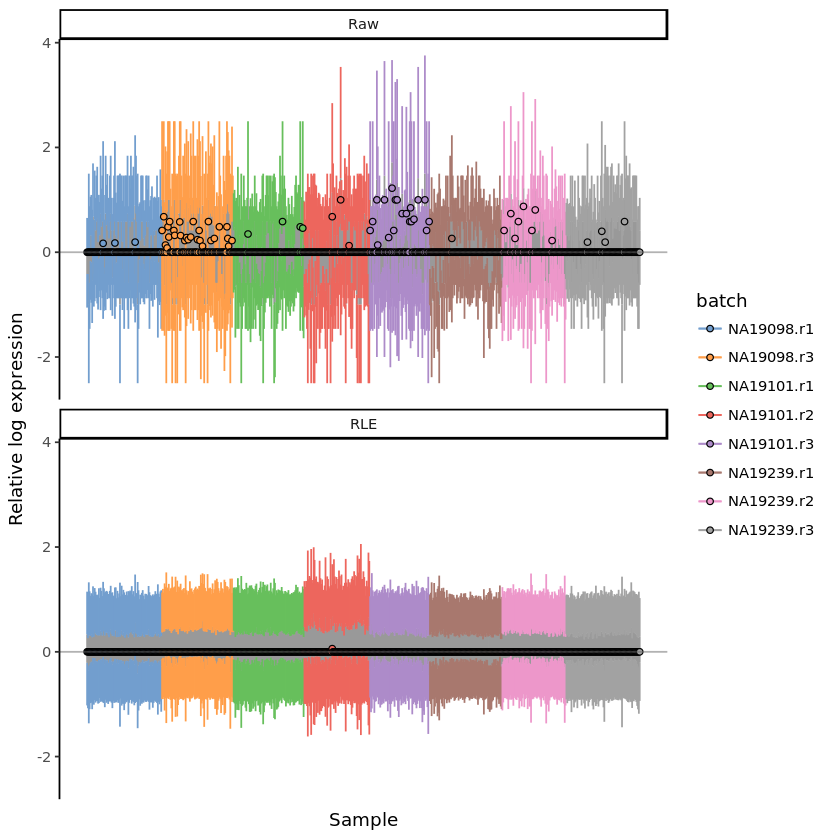

In [4]:
# SF:
umi.qc <- normaliseExprs(
    umi.qc,
    method = "RLE", 
    feature_set = endog_genes,
    return_log = TRUE,
    return_norm_as_exprs = TRUE
)

plotPCA(
    umi.qc[endog_genes, ],
    colour_by = "batch",
    size_by = "total_features",
    shape_by = "individual"
)

plotRLE(
    umi.qc[endog_genes, ], 
    exprs_mats = list(Raw = "logcounts_raw", RLE = "logcounts"),
    exprs_logged = c(TRUE, TRUE),
    colour_by = "batch"
)

# Gives similar clustering to that of CPM, and the RLE has the same profile, albeit the NA19101.r2 batch is spikier

Warning message in normalizeSCE(object, exprs_values = exprs_values, return_log = return_log, :
“spike-in transcripts in 'ERCC' should have their own size factors”

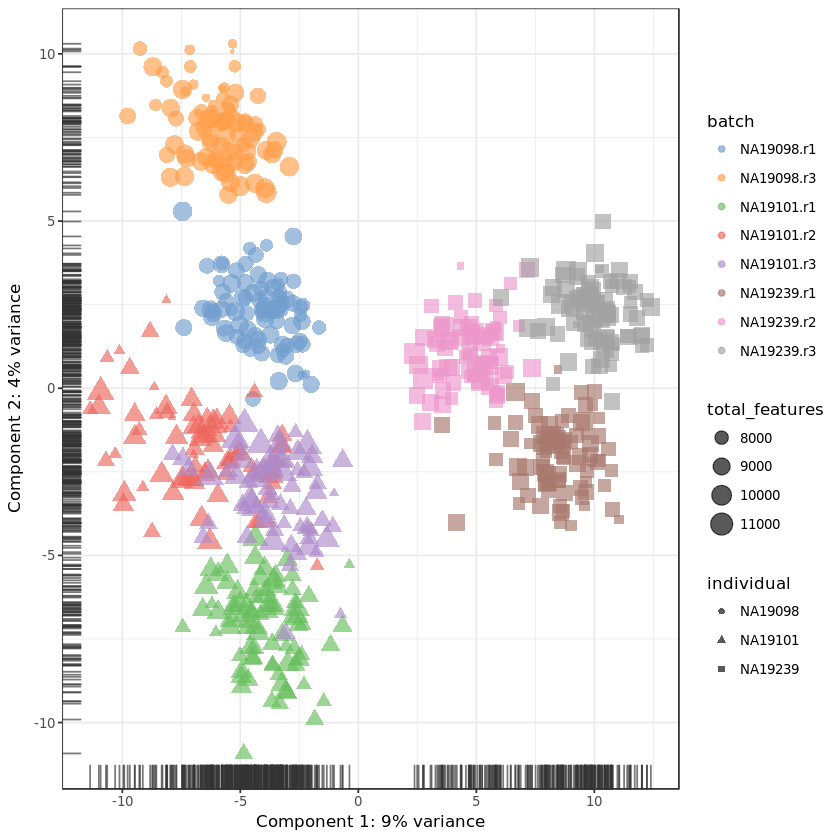

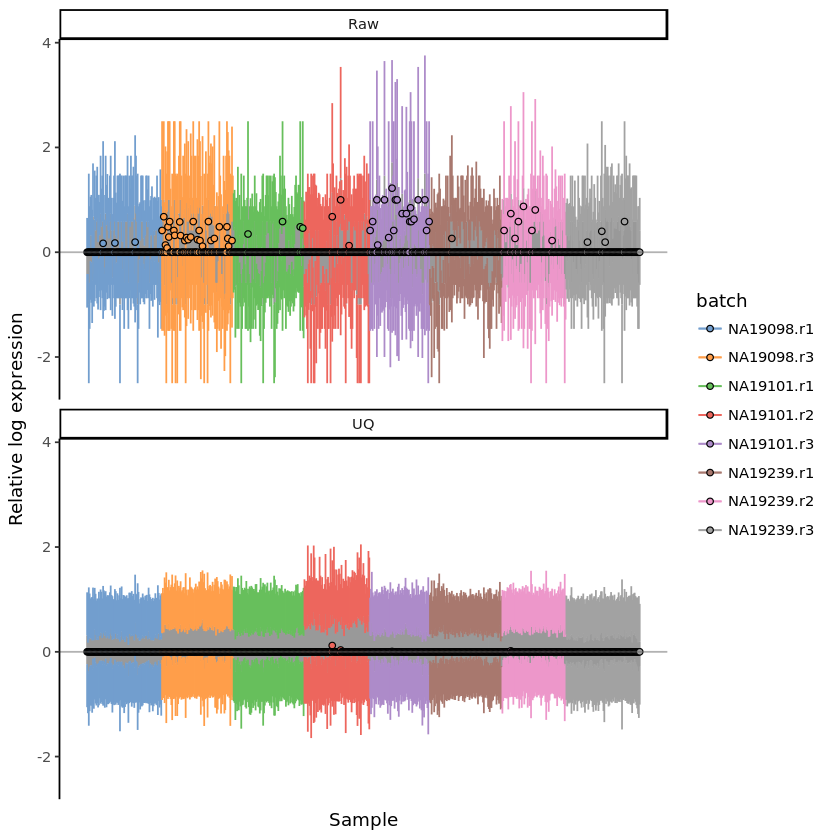

In [5]:
# UQ
umi.qc <- normaliseExprs(
    umi.qc,
    method = "upperquartile", 
    feature_set = endog_genes,
    p = 0.99,
    return_log = TRUE,
    return_norm_as_exprs = TRUE
)

plotPCA(
    umi.qc[endog_genes, ],
    colour_by = "batch",
    size_by = "total_features",
    shape_by = "individual"
)

plotRLE(
    umi.qc[endog_genes, ], 
    exprs_mats = list(Raw = "logcounts_raw", UQ = "logcounts"),
    exprs_logged = c(TRUE, TRUE),
    colour_by = "batch"
)

# Oddly the clustering seems to be flipped on PC2, but otherwise identical.
# The RLE shows more variation per batch

Warning message in normalizeSCE(object, exprs_values = exprs_values, return_log = return_log, :
“spike-in transcripts in 'ERCC' should have their own size factors”

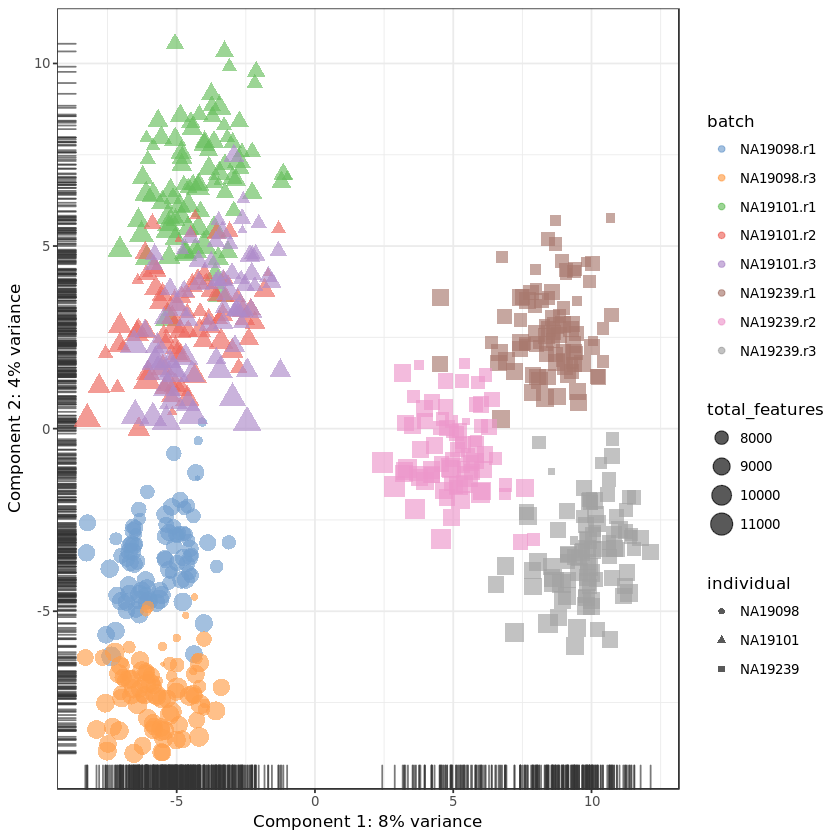

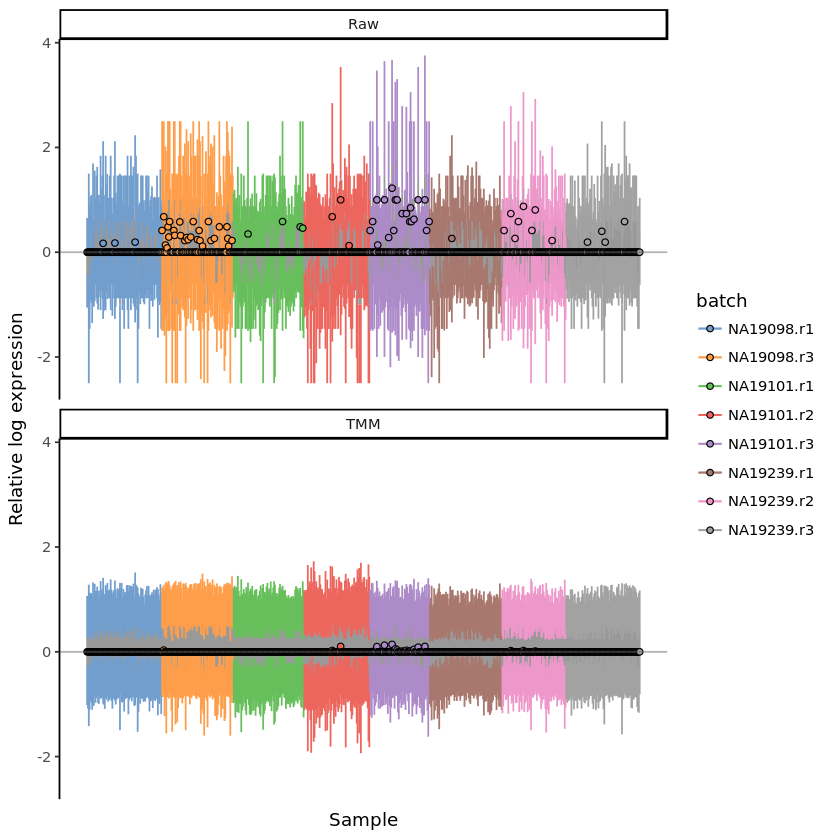

In [6]:
# TMM
umi.qc <- normaliseExprs(
    umi.qc,
    method = "TMM",
    feature_set = endog_genes,
    return_log = TRUE,
    return_norm_as_exprs = TRUE
)

plotPCA(
    umi.qc[endog_genes, ],
    colour_by = "batch",
    size_by = "total_features",
    shape_by = "individual"
)

plotRLE(
    umi.qc[endog_genes, ], 
    exprs_mats = list(Raw = "logcounts_raw", TMM = "logcounts"),
    exprs_logged = c(TRUE, TRUE),
    colour_by = "batch"
)

# blue and orange seem to mix a little more, but we are still seeing the same cluster

Warning message in .local(object, ...):
“spike-in transcripts in 'ERCC' should have their own size factors”

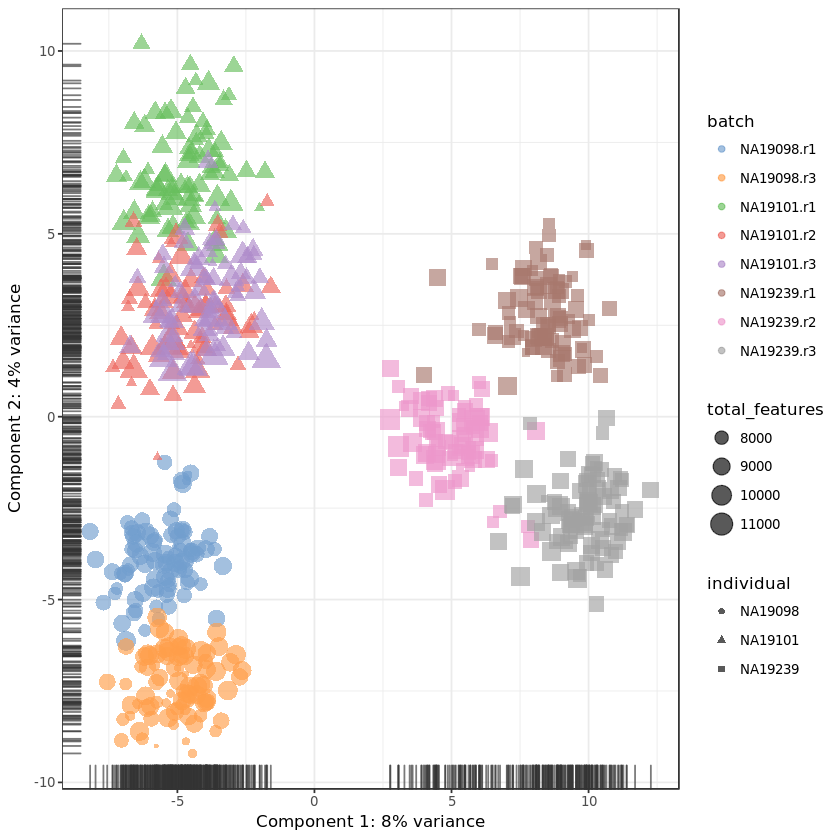

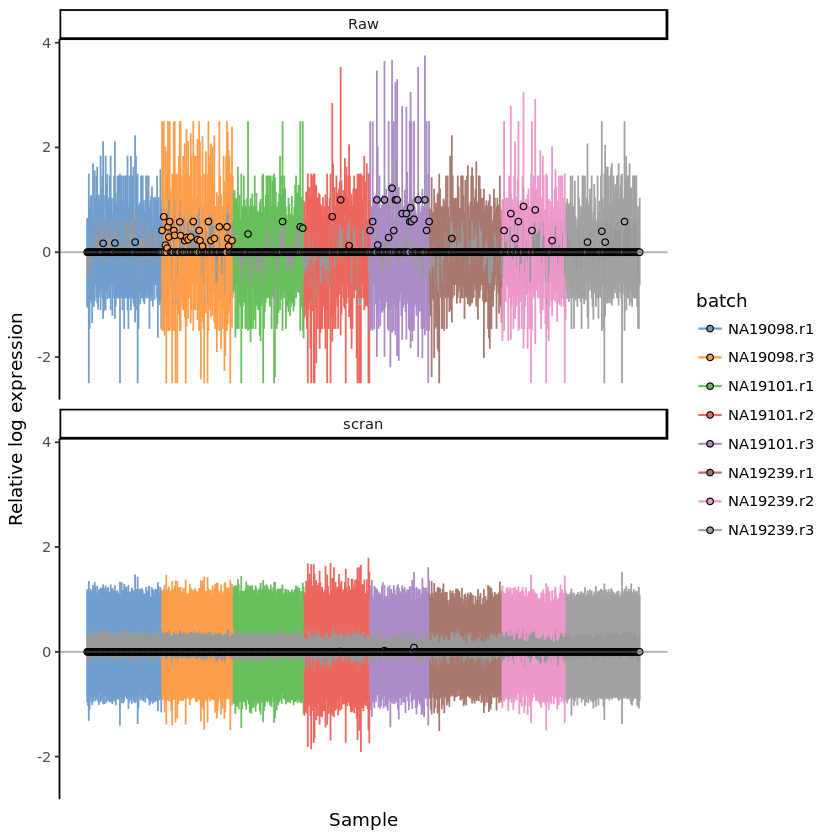

In [7]:
# SCRAN
qclust <- quickCluster(umi.qc, min.size = 30)
umi.qc <- computeSumFactors(umi.qc, sizes = 15, clusters = qclust)
umi.qc <- normalize(umi.qc)

plotPCA(
    umi.qc[endog_genes, ],
    colour_by = "batch",
    size_by = "total_features",
    shape_by = "individual"
)

plotRLE(
    umi.qc[endog_genes, ], 
    exprs_mats = list(Raw = "logcounts_raw", scran = "logcounts"),
    exprs_logged = c(TRUE, TRUE),
    colour_by = "batch"
)

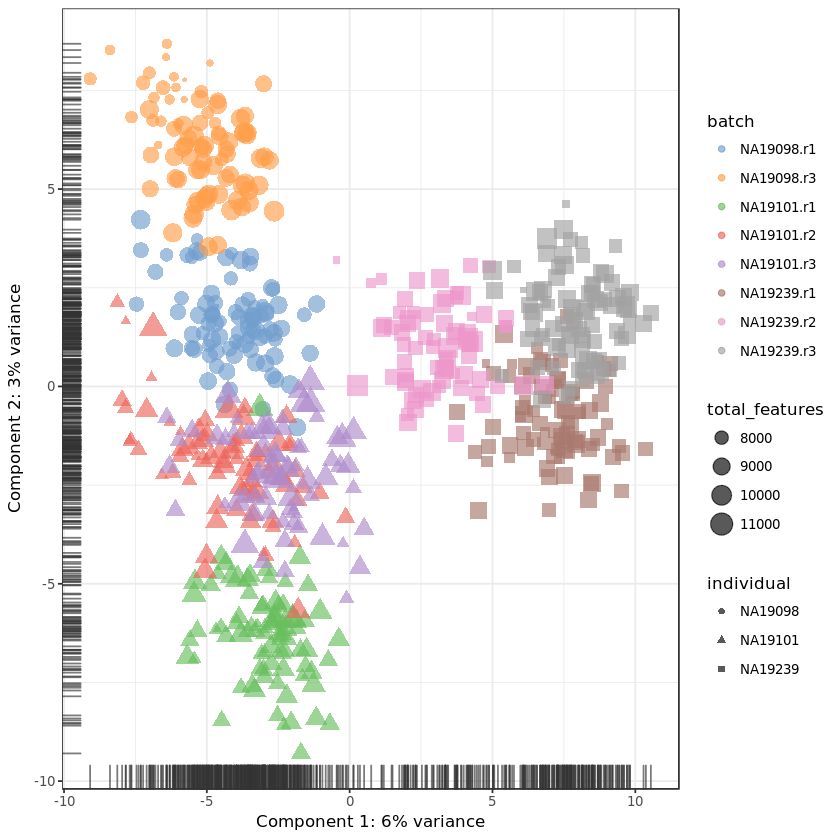

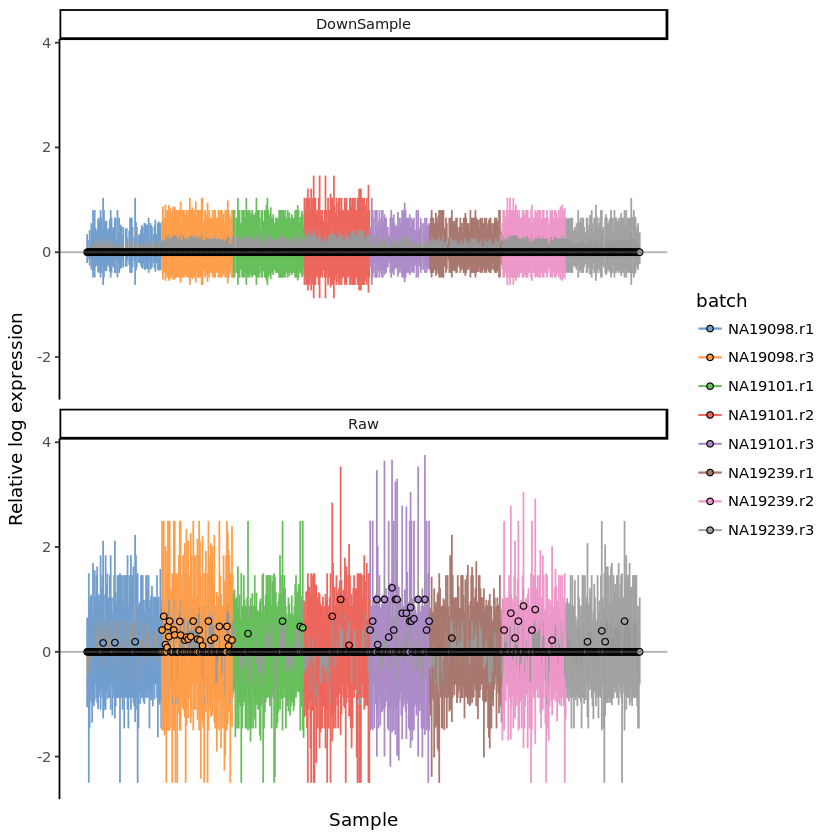

In [8]:
# Downsampling
logcounts(umi.qc) <- log2(Down_Sample_Matrix(counts(umi.qc)) + 1)
plotPCA(
    umi.qc[endog_genes, ],
    colour_by = "batch",
    size_by = "total_features",
    shape_by = "individual"
)

plotRLE(
    umi.qc[endog_genes, ], 
    exprs_mats = list(Raw = "logcounts_raw", DownSample = "logcounts"),
    exprs_logged = c(TRUE, TRUE),
    colour_by = "batch"
)



In [9]:
# So now we have accounted for library size, but we still need to account for other confouders:
# - Technical confounders: batch effects -- difference in reagents, isolation methods, technician, time of day.
#    - We need to make sure that these sources of variation are not related our biological signal.
#    - Approaches: use spike-ins, or housekeeping genes, or endogenous genes -- all with known expression values.

# Advantages and disadvantages of using spike-ins:
# - pro: Same amount of ERCC is added to each cell. In theory, any variability in ERCC genes should be due to 
#       technical noise.
# - pro: Endogenous genes are affected by both technical noise and biological variability, so ERCCs are better option.
# - We can remove technical noise by fitting a model to the spike-ins and subtracting this from the endogenous genes.
# - This should leave is biological variability only.
#    - Can be performed by BASiCS, scLVM, RUVg -- each with their own noise models and fitting procedures.
#
# - However, you can also identify genes which have significant variation from just technical noise "highly-variable genes"
#   But it's harder to do with spike-ins (particularly ERCC) where their variaility can actually be higher than the 
#   endogenous genes.
#
# - Given this issue with spike-ins, you can often get better results from the endogenous genes, where you have a large 
#   number of endogenous genes that are not likely to vary systematically between cells, and where techinical effects
#   to affect a large number of genes than such methods can perform well.

In [5]:
# Let's explore these two appraches: Spike-Ins and Endogenous Genes

library(scRNA.seq.funcs)
library(RUVSeq)
library(scater)
library(SingleCellExperiment)
library(scran)
library(kBET)
library(sva) # Combat
library(edgeR)
set.seed(1234567)
options(stringsAsFactors = FALSE)
umi <- readRDS("tung/umi.rds")
umi.qc <- umi[rowData(umi)$use, colData(umi)$use]
endog_genes <- !rowData(umi.qc)$is_feature_control
erccs <- rowData(umi.qc)$is_feature_control

qclust <- quickCluster(umi.qc, min.size = 30)
umi.qc <- computeSumFactors(umi.qc, sizes = 15, clusters = qclust)
umi.qc <- normalize(umi.qc)



Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain intro

In [6]:
# Removing technical noise and correcting batch effects is performed by the Remove Unwatned Variation RUVSeq tool.
# It works as follows:
#  - For n samples and J genes, we make a "generalised linear model" GLM, where the RNA-Seq read counts are regressed
#    on not only the known covariates of interest, but also the on unknown factors of unwanted variation.
#      Log E[Y|W,X,O] = Wa + Xb + O
#
#      - Y is the n x J gene expression matrix (of read counts)
#      - W is the n x k matrix of corresponding unwanted factors
#      - O is the n x J matrix of offsets (either zero, or estimated with some other normalisation procedure)
#   - We cannot estimate W, a, b, and k simulataneously, so instead we fix k and calculate W based on three methods:
#          - RUVg, negative control genes (ERCCs) assumed to have constant expression across samples
#          - RUBs, centered (technical/replicated/negative) control samples for which covariates are constant.
#          - RUVr, residuals from a first-pass GLM regression of counts on the covariates of interest
#

# RUVg
ruvg <- RUVg(counts(umi.qc), erccs, k = 1)
assay(umi.qc, "ruvg1") <- log2(
    t(t(ruvg$normalizedCounts) / colSums(ruvg$normalizedCounts) * 1e6) + 1
)
ruvg <- RUVg(counts(umi.qc), erccs, k = 10)
assay(umi.qc, "ruvg10") <- log2(
    t(t(ruvg$normalizedCounts) / colSums(ruvg$normalizedCounts) * 1e6) + 1
)

# RUVs
scIdx <- matrix(-1, ncol = max(table(umi.qc$individual)), nrow = 3)
tmp <- which(umi.qc$individual == "NA19098")
scIdx[1, 1:length(tmp)] <- tmp
tmp <- which(umi.qc$individual == "NA19101")
scIdx[2, 1:length(tmp)] <- tmp
tmp <- which(umi.qc$individual == "NA19239")
scIdx[3, 1:length(tmp)] <- tmp
cIdx <- rownames(umi.qc)
ruvs <- RUVs(counts(umi.qc), cIdx, k = 1, scIdx = scIdx, isLog = FALSE)
assay(umi.qc, "ruvs1") <- log2(
    t(t(ruvs$normalizedCounts) / colSums(ruvs$normalizedCounts) * 1e6) + 1
)
ruvs <- RUVs(counts(umi.qc), cIdx, k = 10, scIdx = scIdx, isLog = FALSE)
assay(umi.qc, "ruvs10") <- log2(
    t(t(ruvs$normalizedCounts) / colSums(ruvs$normalizedCounts) * 1e6) + 1
)




In [17]:
# Combat
#  - For an experiment with a balanced design(?), you can Combat batch effects whilst preserving biological effects by 
#    specifying the biological effects using the mod parameter.
#  - However, our tung data contains multiple experiment replicates, rather than a balanced desgn and so using mod will
#    only result in an error:

#combat_data <- logcounts(umi.qc)
#mod_data <- as.data.frame(t(combat_data))
# Basic batch removal
#mod0 = model.matrix(~ 1, data = mod_data) 
# Preserve biological variability
#mod1 = model.matrix(~ umi.qc$individual, data = mod_data) 
# adjust for total genes detected
#mod2 = model.matrix(~ umi.qc$total_features, data = mod_data)
#assay(umi.qc, "combat") <- ComBat(
#    dat = t(mod_data), 
#    batch = factor(umi.qc$batch), 
#    mod = mod0,
#    par.prior = TRUE,
#    prior.plots = FALSE
#)
#
#assay(umi.qc, "combat_tf") <- ComBat(
#    dat = t(mod_data), 
#    batch = factor(umi.qc$batch), 
#    mod = mod2,
#    par.prior = TRUE,
#    prior.plots = FALSE
#)


In [ ]:
# mnnCorrect
# - assumes batches share at least 1 biological condition with another batch. Works well for balanced designed exper.
#  But the tung data has multiple replicates for each individual, rather for each batch, so we will have to 
#  normalise each individual seperately → we will remove batch effects between batches for the same individual, but not
#  batch effects between batches in different individuals.
#
# So here we will merge replicates from each individual to form three seperate batches.
do_mnn <- function(data.qc) {
    batch1 <- logcounts(data.qc[, data.qc$replicate == "r1"])
    batch2 <- logcounts(data.qc[, data.qc$replicate == "r2"])
    batch3 <- logcounts(data.qc[, data.qc$replicate == "r3"])
    
    if (ncol(batch2) > 0) {
        x = mnnCorrect(
          batch1, batch2, batch3,  
          k = 20,
          sigma = 0.1,
          cos.norm.in = TRUE,
          svd.dim = 2
        )
        res1 <- x$corrected[[1]]
        res2 <- x$corrected[[2]]
        res3 <- x$corrected[[3]]
        dimnames(res1) <- dimnames(batch1)
        dimnames(res2) <- dimnames(batch2)
        dimnames(res3) <- dimnames(batch3)
        return(cbind(res1, res2, res3))
    } else {
        x = mnnCorrect(
          batch1, batch3,  
          k = 20,
          sigma = 0.1,
          cos.norm.in = TRUE,
          svd.dim = 2
        )
        res1 <- x$corrected[[1]]
        res3 <- x$corrected[[2]]
        dimnames(res1) <- dimnames(batch1)
        dimnames(res3) <- dimnames(batch3)
        return(cbind(res1, res3))
    }
}

indi1 <- do_mnn(umi.qc[, umi.qc$individual == "NA19098"])
indi2 <- do_mnn(umi.qc[, umi.qc$individual == "NA19101"])
indi3 <- do_mnn(umi.qc[, umi.qc$individual == "NA19239"])

assay(umi.qc, "mnn") <- cbind(indi1, indi2, indi3)

# For a balanced design: 
#assay(umi.qc, "mnn") <- mnnCorrect(
#    list(B1 = logcounts(batch1), B2 = logcounts(batch2), B3 = logcounts(batch3)),  
#    k = 20,
#    sigma = 0.1,
#    cos.norm = TRUE,
#    svd.dim = 2
#)



In [ ]:
## Simple General linear models
# much more simpler than combat -- corrects for batches in balanced experimental designs, so we have to again remove
# for batch effects on a per individual basis.
# - Here we won't, and will just naively correct for all
glm_fun <- function(g, batch, indi) {
  model <- glm(g ~ batch + indi)
  model$coef[1] <- 0 # replace intercept with 0 to preserve reference batch.
  return(model$coef)
}
effects <- apply(
    logcounts(umi.qc), 
    1, 
    glm_fun, 
    batch = umi.qc$batch, 
    indi = umi.qc$individual
)
corrected <- logcounts(umi.qc) - t(effects[as.numeric(factor(umi.qc$batch)), ])
assay(umi.qc, "glm") <- corrected

# - And here we correct on per individual basis
glm_fun1 <- function(g, batch) {
  model <- glm(g ~ batch)
  model$coef[1] <- 0 # replace intercept with 0 to preserve reference batch.
  return(model$coef)
}

do_glm <- function(data.qc) {
    effects <- apply(
        logcounts(data.qc), 
        1, 
        glm_fun1, 
        batch = data.qc$batch
    )
    corrected <- logcounts(data.qc) - t(effects[as.numeric(factor(data.qc$batch)), ])
    return(corrected)
}
indi1 <- do_glm(umi.qc[, umi.qc$individual == "NA19098"])
indi2 <- do_glm(umi.qc[, umi.qc$individual == "NA19101"])
indi3 <- do_glm(umi.qc[, umi.qc$individual == "NA19239"])

assay(umi.qc, "glm_indi") <- cbind(indi1, indi2, indi3);


In [ ]:
# comparing different confounder removal strategies: Which one is the best?
for(n in assayNames(umi.qc)) {
    print(
        plotPCA(
            umi.qc[endog_genes, ],
            colour_by = "batch",
            size_by = "total_features",
            shape_by = "individual",
            exprs_values = n
        ) +
        ggtitle(n)
    )
}

# These plots are hard to interpret

In [ ]:
# We can also repeat the analysis from the previous chapter ("Identifying confounding factors") to see if our batch
# effects have been removed.

for(n in assayNames(umi.qc)) {
    print(
        plotQC(
            umi.qc[endog_genes, ],
            type = "expl",
            exprs_values = n,
            variables = c(
                "total_features",
                "total_counts",
                "batch",
                "individual",
                "pct_counts_ERCC",
                "pct_counts_MT"
            )
        ) +
        ggtitle(n)
    )
}

In [7]:
# One other strategy is to look for batch effects is for intermingling points of data. If there are no batch effects
# then the proportion of cells from each batch in any local region should be equal to to the global proportion of cells
# in each batch! (i.e. global prop of cells ~ local prop of cells in each batch.)
compare_kBET_results <- function(sce){
    indiv <- unique(sce$individual)
    norms <- assayNames(sce) # Get all normalizations
    results <- list()
    for (i in indiv){ 
        for (j in norms){
            tmp <- kBET(
                df = t(assay(sce[,sce$individual== i], j)), 
                batch = sce$batch[sce$individual==i], 
                heuristic = TRUE, 
                verbose = FALSE, 
                addTest = FALSE, 
                plot = FALSE)
            results[[i]][[j]] <- tmp$summary$kBET.observed[1]
        }
    }
    return(as.data.frame(results))
}

eff_debatching <- compare_kBET_results(umi.qc)

Loading required package: reshape2
Loading required package: RColorBrewer


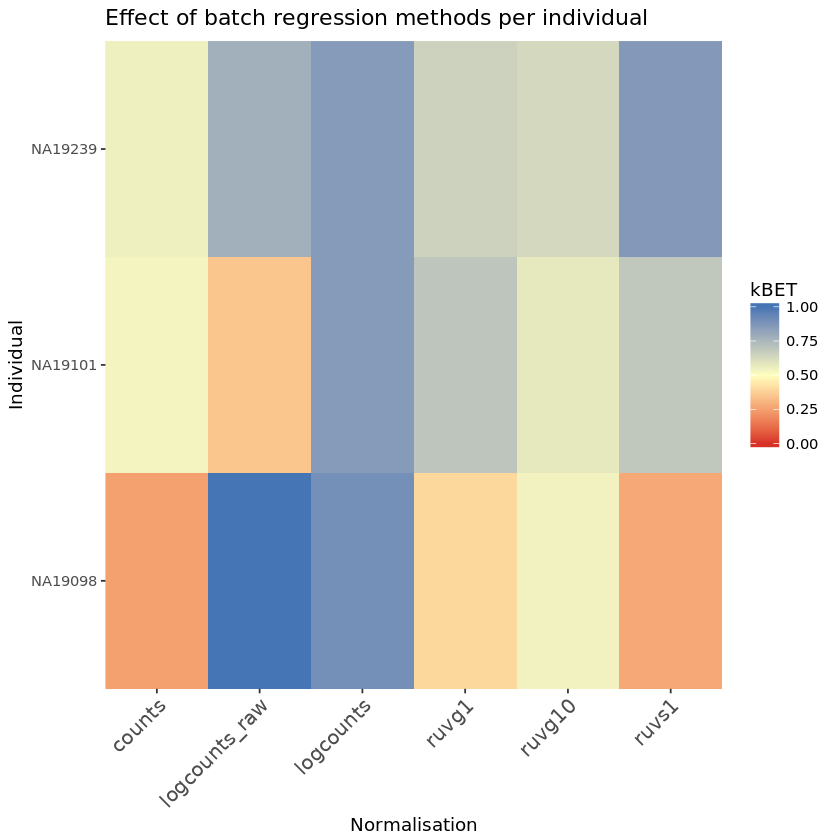

In [8]:
require("reshape2")
require("RColorBrewer")
# Plot results
dod <- melt(as.matrix(eff_debatching),  value.name = "kBET")
colnames(dod)[1:2] <- c("Normalisation", "Individual")

colorset <- c('gray', brewer.pal(n = 9, "RdYlBu"))

ggplot(dod, aes(Normalisation, Individual, fill=kBET)) +  
    geom_tile() +
    scale_fill_gradient2(
        na.value = "gray",
        low = colorset[2],
        mid=colorset[6],
        high = colorset[10],
        midpoint = 0.5, limit = c(0,1)) +
    scale_x_discrete(expand = c(0, 0)) +
    scale_y_discrete(expand = c(0, 0)) + 
    theme(
        axis.text.x = element_text(
            angle = 45, 
            vjust = 1, 
            size = 12, 
            hjust = 1
        )
    ) + 
    ggtitle("Effect of batch regression methods per individual")